## Import Necessary Libraries

In [1]:
# Data Collection
import praw
import pandas as pd
import time
from datetime import datetime, timedelta

# Text Cleaning & Sentiment Analysis & Topic Analysis
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import emoji
import re
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Network Analysis & SIR & Time Series Analysis
import networkx as nx
from collections import defaultdict
import random
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


/Users/junjielai/anaconda3/envs/data/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Collection

In [ ]:
# Initialize PRAW
reddit = praw.Reddit(
    client_id='',
    client_secret='',
    user_agent='echo_chamber_search'
)

# Target Subreddits Lists
democrat_subreddits = ['Democrats', 'liberal']
republican_subreddits = ['Republican', 'Conservative']
all_subreddits = democrat_subreddits + republican_subreddits

# Define the date range
start_date = datetime(2024, 7, 23)
end_date = datetime.now()

# Set retry parameters
MAX_RETRIES = 10
RETRY_BACKOFF = 10  # seconds

# Identify collect_data with progress bar
def collect_data(subreddits, limit=100):
    posts_data = []
    comments_data = []

    for subreddit_name in subreddits:
        subreddit = reddit.subreddit(subreddit_name)
        print(f"Collecting data from r/{subreddit_name}...")

        retries = 0  # Initialize retry count for each subreddit

        # Initialize tqdm progress bar for the collection process
        with tqdm(total=limit, desc=f'Collecting from r/{subreddit_name}', unit='post') as pbar:
            while retries < MAX_RETRIES:
                try:
                    for submission in subreddit.top(time_filter="year",limit=limit):
                        # posts
                        submission_date = datetime.utcfromtimestamp(submission.created_utc)
                        if submission_date < start_date:
                            # Skip posts beyond the start date
                            continue
                        if submission_date > end_date:
                            # Skip posts beyond the end date
                            continue
                        posts_data.append({
                            'post_id': submission.id,
                            'subreddit': subreddit_name,
                            'author': str(submission.author),
                            'title': submission.title,
                            'selftext': submission.selftext,
                            'created_utc': submission.created_utc,
                            'score': submission.score,
                            'num_comments': submission.num_comments
                        })

                        # comments
                        submission.comments.replace_more(limit=None)
                        for comment in submission.comments.list():
                            comments_data.append({
                                'comment_id': comment.id,
                                'subreddit': subreddit_name,
                                'post_id': submission.id,
                                'parent_id': comment.parent_id,
                                'author': str(comment.author),
                                'body': comment.body,
                                'created_utc': comment.created_utc,
                                'score': comment.score
                            })

                        pbar.update(1)  # Update progress bar for each post collected
                        time.sleep(1)

                    retries = 0  # Reset retries if collection is successful
                    break  # Exit while loop if no errors occurred

                except Exception as e:
                    # Handle 429 Too Many Requests error by waiting and retrying
                    if hasattr(e, 'response') and e.response.status_code == 429:
                        print(f"429 Too Many Requests: Retrying in {RETRY_BACKOFF} seconds...")
                        time.sleep(RETRY_BACKOFF)
                        retries += 1
                    else:
                        print(f"An error occurred: {e}")
                        break  # Exit while loop on non-429 errors

        print(f"  Number of posts: {len(posts_data)}")
        print(f"  Number of comments: {len(comments_data)}")
        time.sleep(2)
    
    return posts_data, comments_data

# Collecting
posts_data, comments_data = collect_data(all_subreddits, limit=500)

# Convert to DataFrames and save to CSV
posts_df = pd.DataFrame(posts_data)
comments_df = pd.DataFrame(comments_data)

# Remove duplicates and filter out deleted/removed content
posts_df.drop_duplicates(subset='post_id', inplace=True)
posts_df = posts_df[~posts_df['selftext'].isin(['[deleted]', '[removed]'])]
comments_df.drop_duplicates(subset='comment_id', inplace=True)
comments_df = comments_df[~comments_df['body'].isin(['[deleted]', '[removed]'])]

# Save posts and comments to CSV files
posts_df.to_csv('reddit_posts.csv', index=False)
comments_df.to_csv('reddit_comments.csv', index=False)

print("The data has been successfully saved as a CSV file.")

## Text Processing

In [2]:
# Directly read data after collection
comments_df = pd.read_csv('reddit_comments.csv')
posts_df = pd.read_csv('reddit_posts.csv')

# Define the text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'@\w+', '@user', text)  # Replace mentions with '@user'
    text = re.sub(r'#\w+', '', text)       # Remove hashtags
    text = re.sub(r'http\S+', 'http', text)  # Replace URLs with 'http'
    text = emoji.demojize(text)             # Convert emojis to text
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove punctuation and numbers
    text = text.strip()
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)
    return text

# Preprocess posts
posts_df['clean_text'] = posts_df['title'].fillna('') + ' ' + posts_df['selftext'].fillna('')
posts_df['clean_text'] = posts_df['clean_text'].apply(preprocess_text)

# Preprocess comments
comments_df['clean_text'] = comments_df['body'].fillna('').apply(preprocess_text)
comments_df['clean_text'].head()

0    join rkamalaharris rtimwalz rdemocrats registe...
1                              way smarter trump today
2        damn he old imagine oldasshit candidate could
3               walz year older harris blew mind found
4             gop wheel trump candidate election cycle
Name: clean_text, dtype: object

## Sentiment Analysis

In [5]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Combine posts and comments
combined_df = pd.concat([
    posts_df[['subreddit', 'author', 'clean_text', 'created_utc']],
    comments_df[['subreddit', 'author', 'clean_text', 'created_utc']]
]).reset_index(drop=True)

# Ensure 'created_utc' is numeric
combined_df['created_utc'] = pd.to_numeric(combined_df['created_utc'], errors='coerce')

# Convert 'created_utc' to datetime
combined_df['date'] = pd.to_datetime(combined_df['created_utc'], unit='s')

# Assign party labels to subreddits
subreddit_party = {
    'Democrats': 'Democrat',
    'liberal': 'Democrat',
    'Republican': 'Republican',
    'Conservative': 'Republican'
}

combined_df['party'] = combined_df['subreddit'].map(subreddit_party)

# Define candidate keywords
democrat_candidates = ['harris','kamala']
republican_candidates = ['trump','don','donald']

# Function to check if text contains any candidate keywords
def contains_candidate(text, candidate_keywords):
    return any(keyword.lower() in text.lower() for keyword in candidate_keywords)

# Filter texts mentioning candidates
combined_df['democrat_candidate_mentioned'] = combined_df['clean_text'].apply(lambda x: contains_candidate(x, democrat_candidates))
combined_df['republican_candidate_mentioned'] = combined_df['clean_text'].apply(lambda x: contains_candidate(x, republican_candidates))

# Extract texts for each candidate
democrat_texts = combined_df[combined_df['democrat_candidate_mentioned']].copy()
republican_texts = combined_df[combined_df['republican_candidate_mentioned']].copy()

# Define the sentiment analysis function
def sentiment_analysis(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)[0]
    scores = outputs.logits.squeeze().numpy()
    scores = torch.softmax(torch.tensor(scores), dim=0).numpy()
    sentiment_score = probs[0] * -1 + probs[2] * 1 
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    sentiment = sentiment_labels[np.argmax(scores)]
    # sentiment_score = scores[np.argmax(scores)]
    return sentiment, sentiment_score

# Apply sentiment analysis with progress bar
tqdm.pandas()

# Analyze sentiments for Democrat candidates
democrat_texts['sentiment'], democrat_texts['sentiment_score'] = zip(*democrat_texts['clean_text'].progress_apply(sentiment_analysis))

# Analyze sentiments for Republican candidates
republican_texts['sentiment'], republican_texts['sentiment_score'] = zip(*republican_texts['clean_text'].progress_apply(sentiment_analysis))

# Save the result
republican_texts.to_csv('republican_sentiment.csv', index=False)
democrat_texts.to_csv('democrats_sentiment.csv', index=False)


100%|██████████| 25559/25559 [11:22<00:00, 37.45it/s]


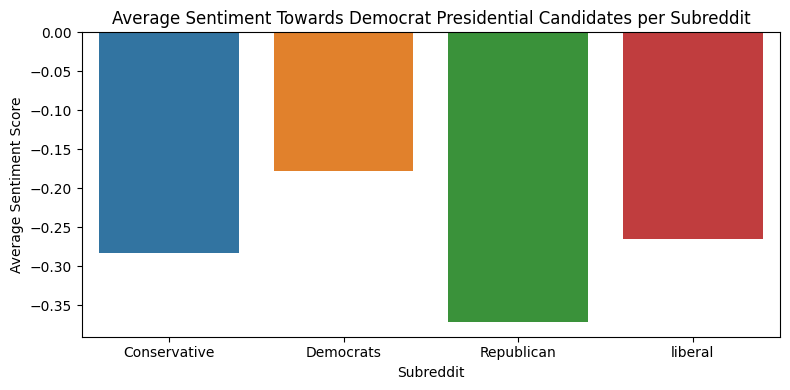

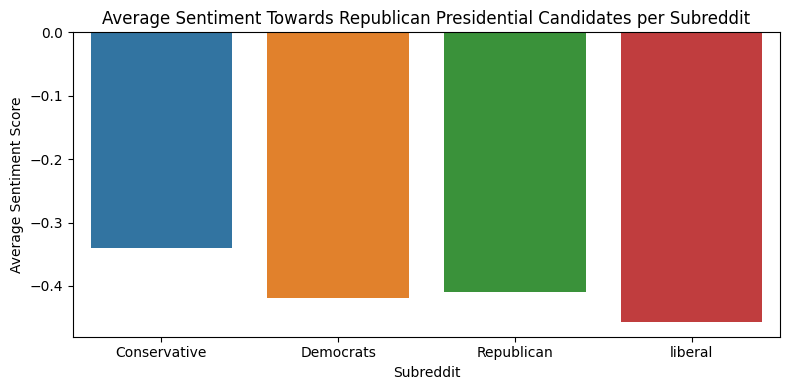

In [6]:
# Function to calculate sentiment over time
def calculate_sentiment(df):
    sentiment= df.groupby(['subreddit'])['sentiment_score'].mean().reset_index()
    return sentiment

# Calculate sentiment for Democrat candidates
sentiment_democrat = calculate_sentiment(democrat_texts)

# Calculate sentiment for Republican candidates
sentiment_republican = calculate_sentiment(republican_texts)

# Plot sentiment for Democrat candidates
plt.figure(figsize=(8, 4))
sns.barplot(x='subreddit', y='sentiment_score', hue='subreddit', data=sentiment_democrat)
plt.xlabel('Subreddit') 
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Towards Democrat Presidential Candidates per Subreddit')
plt.tight_layout()
plt.show()

# Plot sentiment for Republican candidates
plt.figure(figsize=(8, 4))
sns.barplot(x='subreddit', y='sentiment_score', hue='subreddit', data=sentiment_republican)
plt.xlabel('Subreddit') 
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Towards Republican Presidential Candidates per Subreddit')
plt.tight_layout()
plt.show()

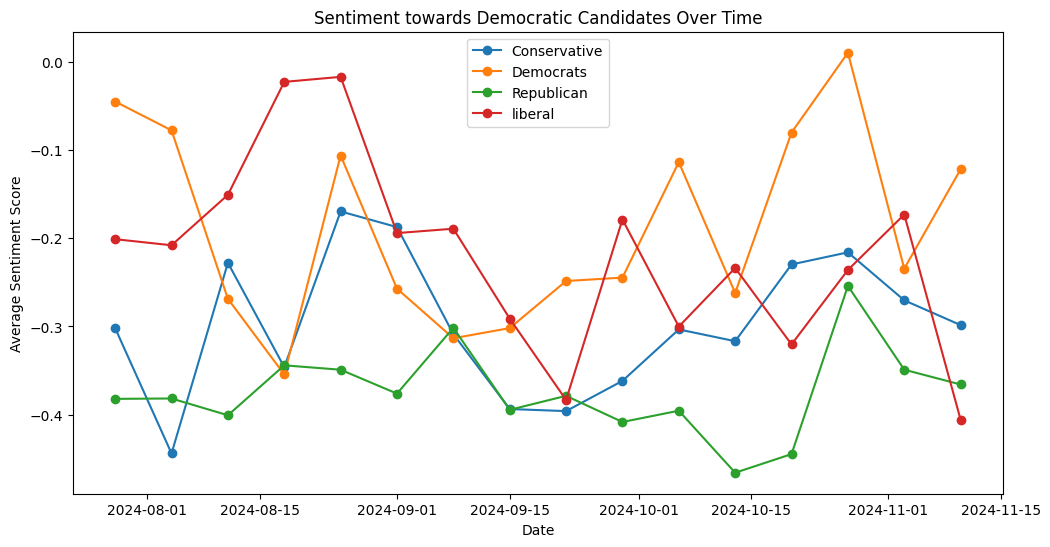

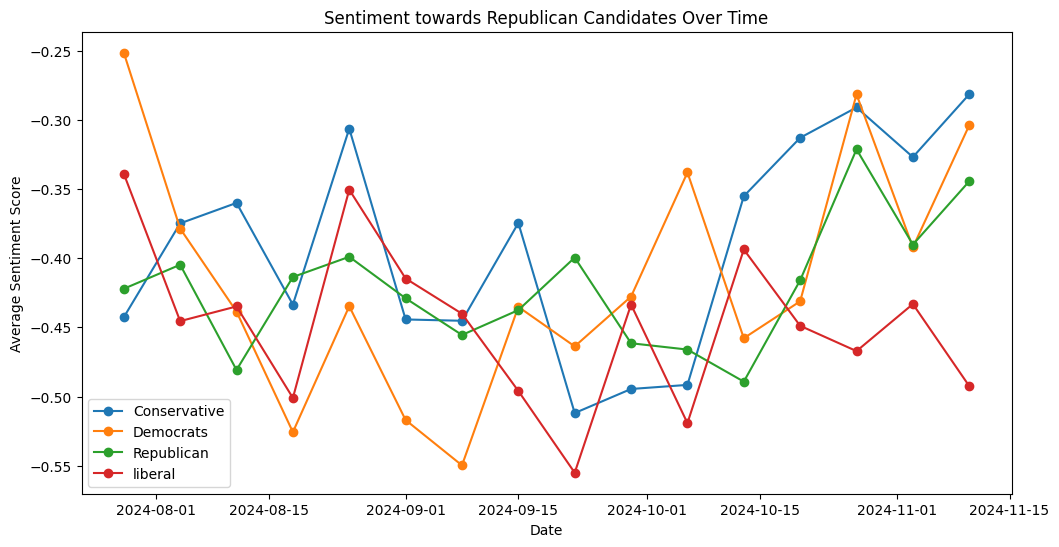

In [7]:
# # Map sentiment labels to numerical values
# sentiment_to_score = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
# democrat_texts['sentiment_value'] = democrat_texts['sentiment'].map(sentiment_to_score)
# republican_texts['sentiment_value'] = republican_texts['sentiment'].map(sentiment_to_score)

# Function to calculate sentiment over time
def calculate_sentiment_over_time(df, time_freq='W'):
    sentiment_over_time = df.groupby([
        pd.Grouper(key='date', freq=time_freq),
        'subreddit'
    ])['sentiment_score'].mean().reset_index()
    return sentiment_over_time

# Calculate sentiment over time for Democrat candidates
sentiment_over_time_democrat = calculate_sentiment_over_time(democrat_texts)

# Calculate sentiment over time for Republican candidates
sentiment_over_time_republican = calculate_sentiment_over_time(republican_texts)

# Plotting function
def plot_sentiment_over_time(sentiment_df, candidate_party):
    plt.figure(figsize=(12,6))
    for subreddit in sentiment_df['subreddit'].unique():
        subreddit_df = sentiment_df[sentiment_df['subreddit'] == subreddit]
        plt.plot(subreddit_df['date'], subreddit_df['sentiment_score'], marker='o', label=f'{subreddit}')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.title(f'Sentiment towards {candidate_party} Candidates Over Time')
    plt.legend()
    plt.show()

# Plot sentiment over time for Democrat candidates
plot_sentiment_over_time(sentiment_over_time_democrat, 'Democratic')

# Plot sentiment over time for Republican candidates
plot_sentiment_over_time(sentiment_over_time_republican, 'Republican')

## Topic Analysis

In [8]:
# Define keywords for each issue
issues_keywords = {
    'Economic Issues': ['tax', 'income', 'economy', 'financial', 'wealth', 'salary', 'wage', 'poverty'],
    'Immigration Issues': ['immigration', 'immigrant', 'migrant', 'border', 'asylum', 'refugee', 'deport'],
    'Israel-Palestine Conflict': ['israel', 'palestine', 'gaza', 'hamas', 'idf', 'jerusalem', 'west bank', 'conflict'],
    'Abortion Issues': ['abortion', 'pro-life', 'pro-choice', 'reproductive rights', 'fetus', 'roe v wade', 'planned parenthood'],
    'LGBTQ Issues': ['lgbt', 'gay', 'lesbian', 'transgender', 'bisexual', 'queer', 'pride', 'homosexual', 'gender identity']
}

In [9]:
# For posts
posts_df['created_utc'] = pd.to_numeric(posts_df['created_utc'], errors='coerce')
posts_df['date'] = pd.to_datetime(posts_df['created_utc'], unit='s')

# For comments
comments_df['created_utc'] = pd.to_numeric(comments_df['created_utc'], errors='coerce')
comments_df['date'] = pd.to_datetime(comments_df['created_utc'], unit='s')

# Combine all the posts and comments
all_posts = posts_df[['subreddit', 'date', 'title', 'clean_text']].copy()
all_comments = comments_df[['subreddit', 'date', 'body', 'clean_text']].copy()

# Combine them together
all_data = pd.concat([all_posts[['subreddit', 'clean_text', 'date']],
                      all_comments[['subreddit', 'clean_text', 'date']]], ignore_index=True)

# Count the numbers of posts and comments in each subreddit
total_content_counts = all_data.groupby('subreddit').size().reset_index(name='total_count')

In [10]:
def filter_data_by_keywords(df, text_column, keywords):
    # Combine keywords into a single regex pattern
    pattern = '|'.join([re.escape(keyword) for keyword in keywords])
    # Use regex to filter rows where the text matches any of the keywords
    mask = df[text_column].str.contains(pattern, case=False, na=False)
    filtered_df = df[mask].copy()
    return filtered_df

In [11]:
# Initialize dictionaries to store filtered data
filtered_posts = {}
filtered_comments = {}

for issue, keywords in issues_keywords.items():
    print(f"Filtering data for issue: {issue}")
    # Filter posts
    posts_filtered = filter_data_by_keywords(posts_df, 'clean_text', keywords)
    
    # Filter comments
    comments_filtered = filter_data_by_keywords(comments_df,'clean_text', keywords)
    
    # Combine posts and comments
    combined_filtered = pd.concat([posts_filtered[['subreddit', 'clean_text','date']], comments_filtered[['subreddit', 'clean_text','date']]], ignore_index=True)
    print(f'Issue: {issue}, Data: {len(combined_filtered)}')
    
    # Store the filtered data
    filtered_posts[issue] = posts_filtered
    filtered_comments[issue] = comments_filtered
    issues_keywords[issue] = combined_filtered

Filtering data for issue: Economic Issues
Issue: Economic Issues, Data: 2856
Filtering data for issue: Immigration Issues
Issue: Immigration Issues, Data: 2025
Filtering data for issue: Israel-Palestine Conflict
Issue: Israel-Palestine Conflict, Data: 755
Filtering data for issue: Abortion Issues
Issue: Abortion Issues, Data: 1169
Filtering data for issue: LGBTQ Issues
Issue: LGBTQ Issues, Data: 760


Computing sentiment for issue: Economic Issues
Computing sentiment for issue: Immigration Issues
Computing sentiment for issue: Israel-Palestine Conflict
Computing sentiment for issue: Abortion Issues
Computing sentiment for issue: LGBTQ Issues


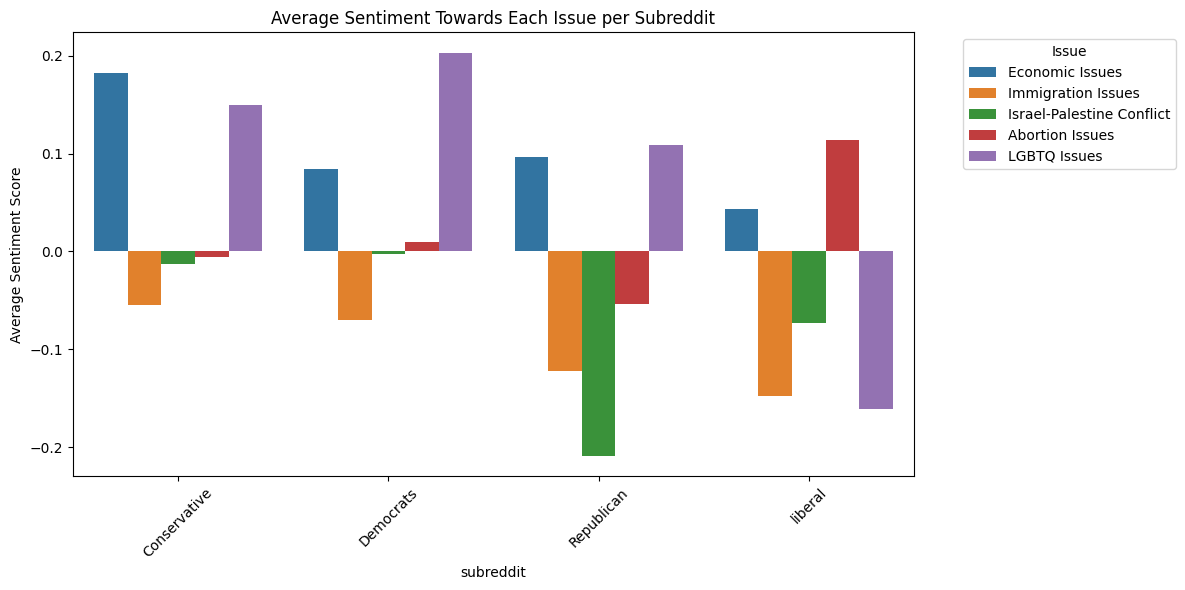

In [12]:
analyzer = SentimentIntensityAnalyzer()

def compute_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

sentiment_results = []

for issue, data in issues_keywords.items():
    print(f"Computing sentiment for issue: {issue}")
    data['sentiment'] = data['clean_text'].apply(compute_sentiment)
    
    sentiment_summary = data.groupby('subreddit')['sentiment'].mean().reset_index()
    sentiment_summary['issue'] = issue
    sentiment_results.append(sentiment_summary)

sentiment_df = pd.concat(sentiment_results, ignore_index=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='subreddit', y='sentiment', hue='issue', data=sentiment_df)
plt.xticks(rotation=45)
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Towards Each Issue per Subreddit')
plt.legend(title='Issue', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

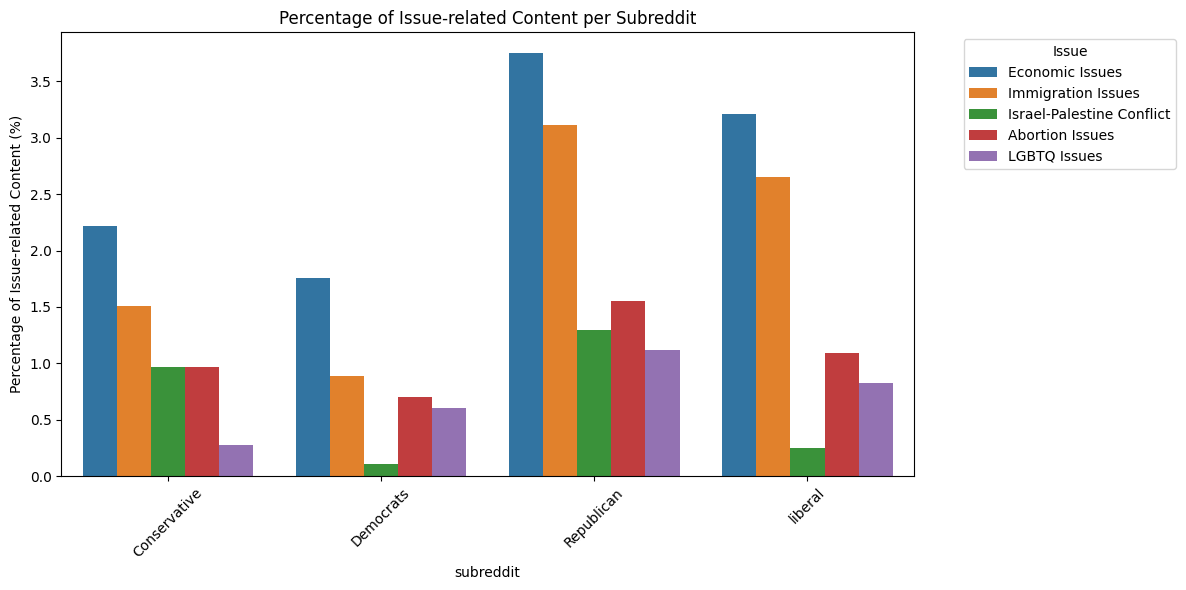

In [13]:
# Calculate the number of posts/comments per subreddit for each issue
# frequency_data = []

# for issue, data in issues_keywords.items():
#     freq = data['subreddit'].value_counts().reset_index()
#     freq.columns = ['subreddit', 'count']
#     freq['issue'] = issue
#     frequency_data.append(freq)

# frequency_df = pd.concat(frequency_data, ignore_index=True)

issue_content_counts = []

for issue, data in issues_keywords.items():
    counts = data.groupby('subreddit').size().reset_index(name='issue_count')
    counts['issue'] = issue
    issue_content_counts.append(counts)

issue_content_counts_df = pd.concat(issue_content_counts, ignore_index=True)

# Merge data
merged_counts = pd.merge(issue_content_counts_df, total_content_counts, on='subreddit', how='left')

# Count Percentage
merged_counts['percentage'] = (merged_counts['issue_count'] / merged_counts['total_count']) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x='subreddit', y='percentage', hue='issue', data=merged_counts)
plt.xticks(rotation=45)
plt.ylabel('Percentage of Issue-related Content (%)')
plt.title('Percentage of Issue-related Content per Subreddit')
plt.legend(title='Issue', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

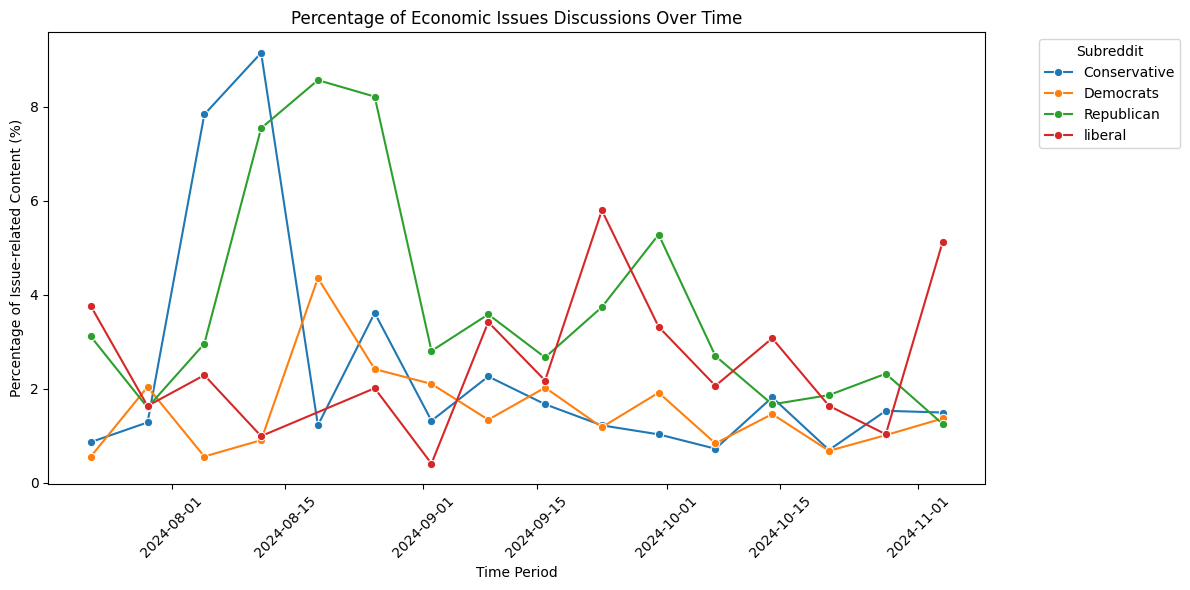

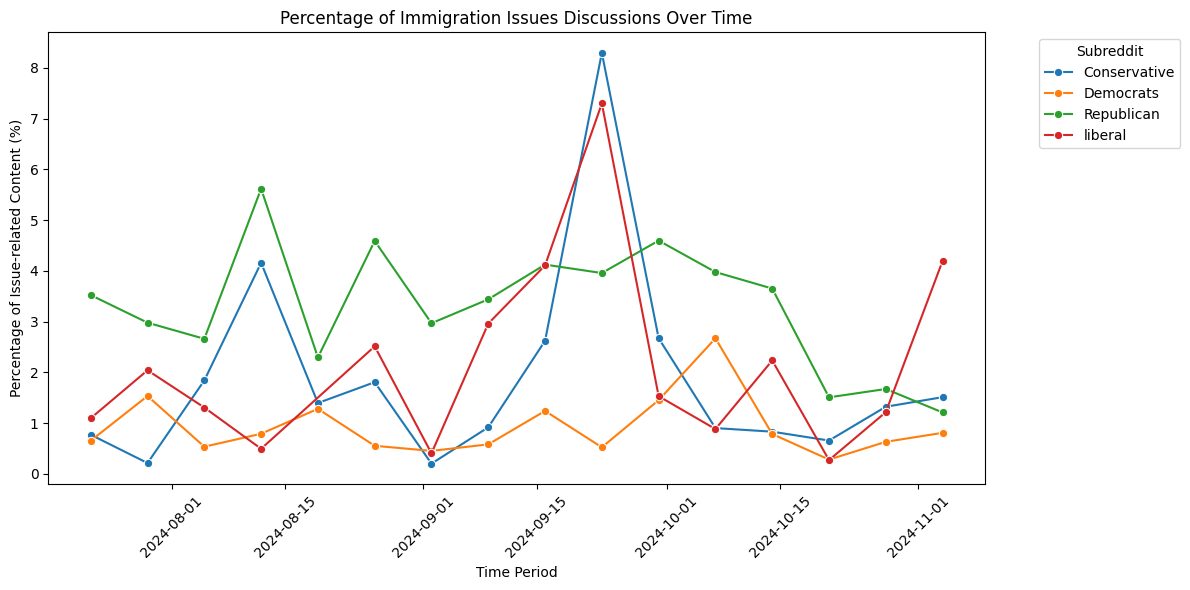

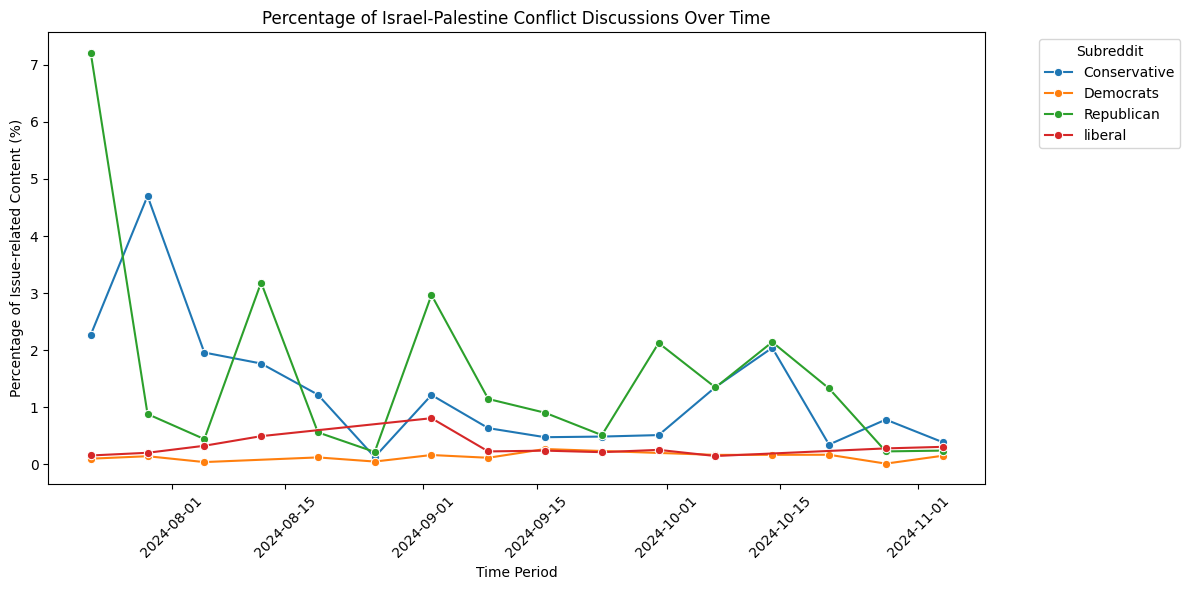

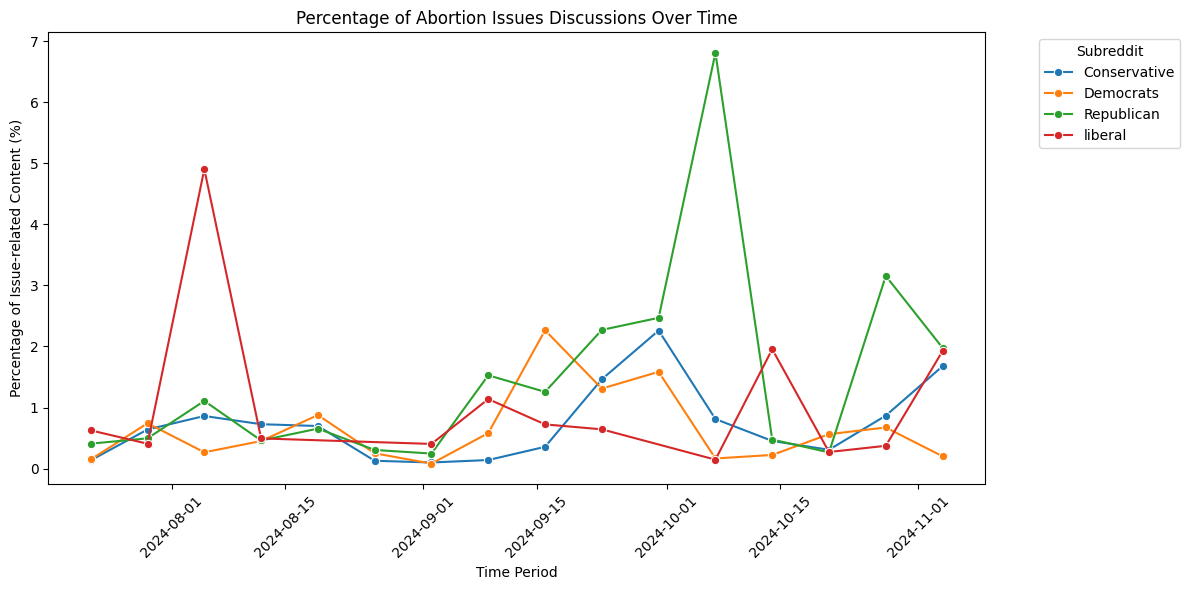

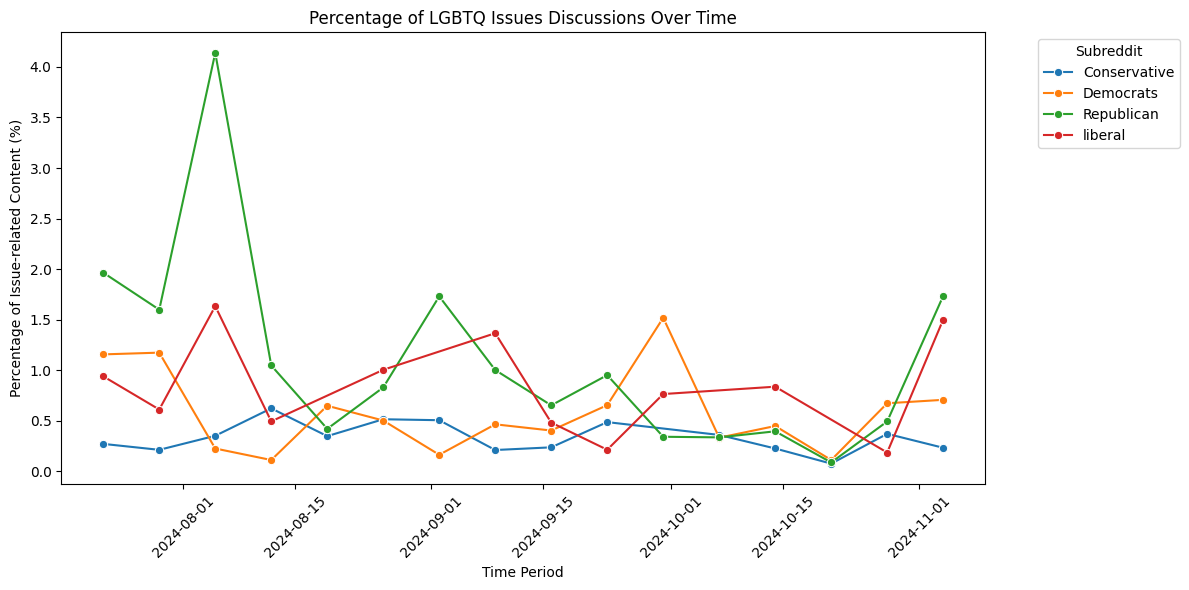

In [14]:
# Add time_period in all_data
time_freq = 'W' # Weekly

all_data['time_period'] = all_data['date'].dt.to_period(time_freq)
all_data['time_period'] = all_data['time_period'].dt.to_timestamp()

# Calculate the total amount of content for each Subreddit in each time period
total_content_time = all_data.groupby(['subreddit', 'time_period']).size().reset_index(name='total_count')

issue_content_time_data = []

for issue, data in issues_keywords.items():
    # Ensure the time_period
    data['time_period'] = data['date'].dt.to_period(time_freq)
    data['time_period'] = data['time_period'].dt.to_timestamp()
    
    counts = data.groupby(['subreddit', 'time_period']).size().reset_index(name='issue_count')
    counts['issue'] = issue
    issue_content_time_data.append(counts)

issue_content_time_df = pd.concat(issue_content_time_data, ignore_index=True)

# Merge data
merged_time_counts = pd.merge(issue_content_time_df, total_content_time, on=['subreddit', 'time_period'], how='left')

# Count percentage
merged_time_counts['percentage'] = (merged_time_counts['issue_count'] / merged_time_counts['total_count']) * 100

for issue in issues_keywords.keys():
    plt.figure(figsize=(12, 6))
    issue_data = merged_time_counts[merged_time_counts['issue'] == issue]
    sns.lineplot(data=issue_data, x='time_period', y='percentage', hue='subreddit', marker='o')
    plt.xticks(rotation=45)
    plt.xlabel('Time Period')
    plt.ylabel('Percentage of Issue-related Content (%)')
    plt.title(f'Percentage of {issue} Discussions Over Time')
    plt.legend(title='Subreddit', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Network Analysis

In [15]:
# Build the interaction network
def build_interaction_network(posts_df, comments_df):
    G = nx.Graph()

    # Add nodes (authors)
    post_authors = set(posts_df['author'])
    comment_authors = set(comments_df['author'])
    all_authors = post_authors.union(comment_authors)
    G.add_nodes_from(all_authors)

    # Add edges between post authors and comment authors
    post_author_dict = posts_df.set_index('post_id')['author'].to_dict()
    for index, comment in comments_df.iterrows():
        comment_author = comment['author']
        post_id = comment['post_id']
        post_author = post_author_dict.get(post_id)
        if post_author:
            G.add_edge(comment_author, post_author)

    # Add edges between comment authors and parent comment authors
    comment_author_dict = comments_df.set_index('comment_id')['author'].to_dict()
    for index, comment in comments_df.iterrows():
        comment_author = comment['author']
        parent_id = comment['parent_id']
        if parent_id.startswith('t1_'):  # If parent is a comment
            parent_comment_id = parent_id.split('_')[1]
            parent_author = comment_author_dict.get(parent_comment_id)
            if parent_author:
                G.add_edge(comment_author, parent_author)

    return G

# Build the network
G = build_interaction_network(posts_df, comments_df)

# Using Louvain algorithm to detect communities
partition = community_louvain.best_partition(G)

# Add community assignments to node properties
nx.set_node_attributes(G, partition, 'community')
print(f"The network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Converting a partition to a community list
community_dict = defaultdict(list)
for node, community_id in partition.items():
    community_dict[community_id].append(node)

# Get a list of communities
communities = list(community_dict.values())
print(f"Detected {len(communities)} communities.")
community_sizes = [len(community) for community in communities]
print(f"Community sizes: {community_sizes}")

# Count modularity
modularity = community_louvain.modularity(partition, G)
print("Modularity:", modularity)

The network has 38791 nodes and 111387 edges.
Detected 18 communities.
Community sizes: [2196, 6896, 2607, 5380, 887, 1975, 7484, 1499, 2404, 266, 1001, 1372, 1108, 409, 576, 1066, 1093, 572]
Modularity: 0.6575400519326534


In [16]:
def evaluate_echo_chamber(G, communities):
    """
    Evaluate the presence of echo chambers by comparing within-community and cross-community interactions.
    :param G: NetworkX graph of user interactions.
    :param communities: List of detected communities.
    :param infection_counts: Simulation results showing infected users over time.
    """
    # Calculate intra-community and inter-community edges
    intra_community_edges = 0
    inter_community_edges = 0

    # Create a dictionary to map users to their respective communities
    community_dict = {}
    for i, community in enumerate(communities):
        for user in community:
            community_dict[user] = i

    # Count intra- and inter-community edges
    for u, v in G.edges():
        if community_dict.get(u) == community_dict.get(v):
            intra_community_edges += 1
        else:
            inter_community_edges += 1

    print(f"Intra-community interactions: {intra_community_edges}")
    print(f"Inter-community interactions: {inter_community_edges}")

# Evaluate the presence of echo chambers
evaluate_echo_chamber(G, communities)

Intra-community interactions: 89531
Inter-community interactions: 21856


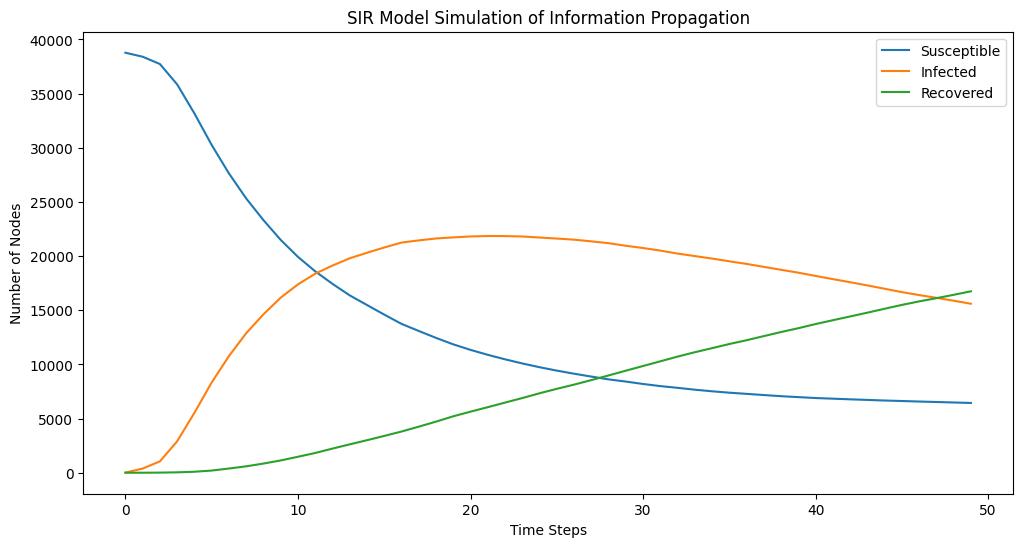

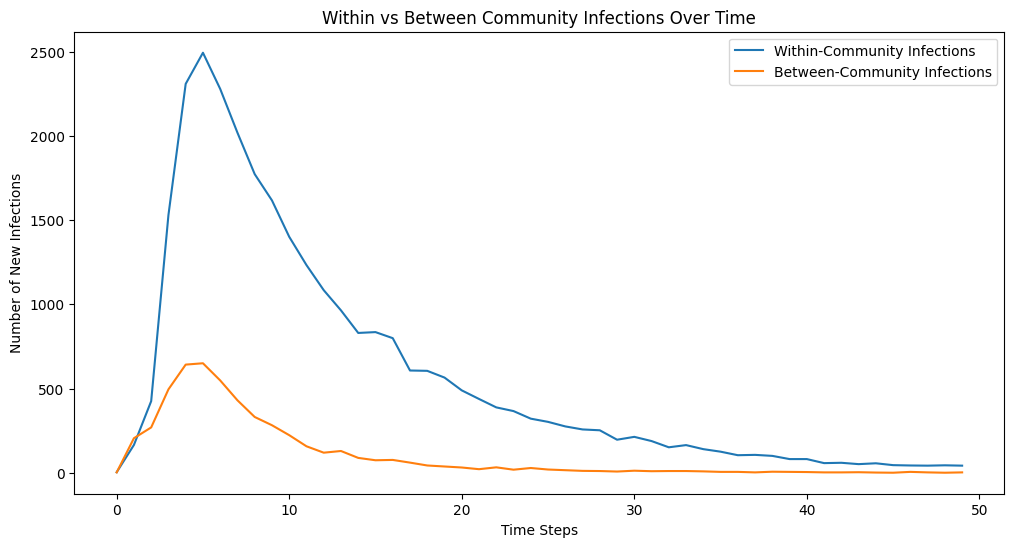

In [17]:
# Parameters for the SIR model
infection_rate = 0.05  # Probability of infection per contact
recovery_rate = 0.02   # Probability of recovery per time step
time_steps = 50        # Number of time steps in the simulation

# Initialize the states of all nodes to 'S' (Susceptible)
for node in G.nodes():
    G.nodes[node]['state'] = 'S'
    G.nodes[node]['community'] = partition.get(node, None)  # Community assignment from previous community detection

# Randomly select initial infected nodes
initial_infected_count = 10
initial_infected = random.sample(list(G.nodes()), k=initial_infected_count)
for node in initial_infected:
    G.nodes[node]['state'] = 'I'

# Lists to keep track of the number of nodes in each state over time
susceptible_counts = []
infected_counts = []
recovered_counts = []

# Lists to track within-community and between-community infections
within_community_infections = []
between_community_infections = []

# Simulation loop
for t in range(time_steps):
    new_infected = []
    new_recovered = []
    for node in G.nodes():
        state = G.nodes[node]['state']
        if state == 'I':
            # Infection process
            for neighbor in G.neighbors(node):
                neighbor_state = G.nodes[neighbor]['state']
                if neighbor_state == 'S':
                    if random.random() < infection_rate:
                        new_infected.append(neighbor)
                        # Check if infection is within community or between communities
                        if G.nodes[node]['community'] == G.nodes[neighbor]['community']:
                            within_community_infections.append((t, node, neighbor))
                        else:
                            between_community_infections.append((t, node, neighbor))
            # Recovery process
            if random.random() < recovery_rate:
                new_recovered.append(node)
    # Update states
    for node in new_infected:
        G.nodes[node]['state'] = 'I'
    for node in new_recovered:
        G.nodes[node]['state'] = 'R'
    # Record counts
    susceptible_count = sum(1 for node in G.nodes() if G.nodes[node]['state'] == 'S')
    infected_count = sum(1 for node in G.nodes() if G.nodes[node]['state'] == 'I')
    recovered_count = sum(1 for node in G.nodes() if G.nodes[node]['state'] == 'R')
    susceptible_counts.append(susceptible_count)
    infected_counts.append(infected_count)
    recovered_counts.append(recovered_count)

# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(range(time_steps), susceptible_counts, label='Susceptible')
plt.plot(range(time_steps), infected_counts, label='Infected')
plt.plot(range(time_steps), recovered_counts, label='Recovered')
plt.xlabel('Time Steps')
plt.ylabel('Number of Nodes')
plt.title('SIR Model Simulation of Information Propagation')
plt.legend()
plt.show()

# Plotting within-community and between-community infections over time
# Counting the number of infections at each time step
within_counts = [0]*time_steps
between_counts = [0]*time_steps

for infection in within_community_infections:
    t, _, _ = infection
    within_counts[t] += 1

for infection in between_community_infections:
    t, _, _ = infection
    between_counts[t] += 1

plt.figure(figsize=(12,6))
plt.plot(range(time_steps), within_counts, label='Within-Community Infections')
plt.plot(range(time_steps), between_counts, label='Between-Community Infections')
plt.xlabel('Time Steps')
plt.ylabel('Number of New Infections')
plt.title('Within vs Between Community Infections Over Time')
plt.legend()
plt.show()

In [ ]:
# Convert timestamps to datetime format
posts_df['date'] = pd.to_datetime(posts_df['created_utc'], unit='s')
comments_df['date'] = pd.to_datetime(comments_df['created_utc'], unit='s')

# Sort comments_df by date
comments_df = comments_df.sort_values('date')
posts_df = posts_df.sort_values('date')

# Define start and end dates
start_date = min(comments_df['date'].min(),posts_df['date'].min())
end_date = max(comments_df['date'].max(),posts_df['date'].max())

# Generate weekly time periods
time_periods = pd.date_range(start=start_date, end=end_date, freq='W')

# Initialize lists
modularity_over_time = []

# Initialize cumulative comments list
cumulative_comments_list = []
cumulative_posts_list = []

for period_end in time_periods[1:]:
    # Get new comments up to the current time period
    new_comments = comments_df[(comments_df['date'] >= time_periods[0]) & (comments_df['date'] <= period_end)]
    new_posts = posts_df[(posts_df['date'] >= time_periods[0]) & (posts_df['date'] <= period_end)]

    # Add new comments to the cumulative list
    cumulative_comments_list.append(new_comments)
    cumulative_posts_list.append(new_posts)

    # Combine cumulative comments
    cumulative_comments = pd.concat(cumulative_comments_list).drop_duplicates().reset_index(drop=True)
    cumulative_posts = pd.concat(cumulative_posts_list).drop_duplicates().reset_index(drop=True)

    print(f"Processing cumulative data up to: {period_end.date()}")

    G_cumulative = build_interaction_network(cumulative_posts,cumulative_comments)
    
    # Community detection
    if G_cumulative.number_of_nodes() > 0 and G_cumulative.number_of_edges() > 0:
        partition = community_louvain.best_partition(G_cumulative)
        modularity = community_louvain.modularity(partition, G_cumulative)
    else:
        modularity = None  # If the network is empty, set modularity to None

    modularity_over_time.append({
        'date': period_end,
        'modularity': modularity
    })

# Convert to DataFrame
modularity_df = pd.DataFrame(modularity_over_time)

# Ensure the 'date' column is datetime type
modularity_df['date'] = pd.to_datetime(modularity_df['date'])

# Drop rows where modularity is None
modularity_df = modularity_df.dropna(subset=['modularity'])

# Filter out the parts where modularity is greater than 0
modularity_df_filtered = modularity_df[modularity_df['modularity'] > 0].copy()

# Plotting the modularity over time
plt.figure(figsize=(12,6))
plt.plot(modularity_df_filtered['date'], modularity_df_filtered['modularity'], marker='o')
plt.xlabel('Date')
plt.ylabel('Modularity')
plt.title('Modularity Over Time')

# Set the x-axis to weekly intervals
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # One tick per week
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Processing cumulative data up to: 2024-08-04
Processing cumulative data up to: 2024-08-11
Processing cumulative data up to: 2024-08-18
Processing cumulative data up to: 2024-08-25
Processing cumulative data up to: 2024-09-01
